In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Training images

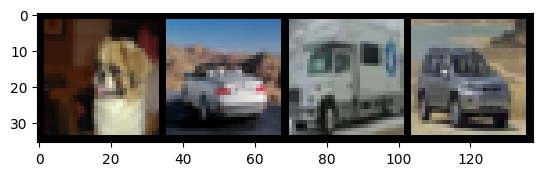

dog car truck car


In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
detaiter = iter(trainloader)
image, labels = next(detaiter)

imshow(torchvision.utils.make_grid(image))
print(" ".join([classes[labels[i]] for i in range(batch_size)]))

## Convolutional Neural Network

$n_{out} = \dfrac{n_{in} + 2p - k}{s} + 1$

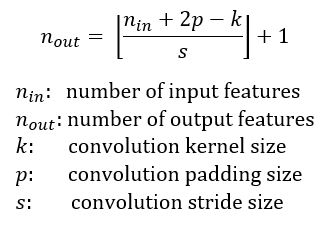

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.fc1 = nn.Linear(64*8*8,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum = 0.1)

In [7]:
for epoch in range(10):
    
    running_loss = 0
    accuracy = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        value, out = torch.max(outputs.data,1)
        accuracy += (out == labels).sum().item()
        
        running_loss += loss.item()
    print(epoch," Epoch",", Loss :",running_loss/len(trainset),", Accuracy :",accuracy/len(trainset))

0  Epoch , Loss : 0.4643897342890501 , Accuracy : 0.31308
1  Epoch , Loss : 0.3312628449963033 , Accuracy : 0.52128
2  Epoch , Loss : 0.26394747297756604 , Accuracy : 0.62824
3  Epoch , Loss : 0.21663272893185728 , Accuracy : 0.69444
4  Epoch , Loss : 0.17830987513948932 , Accuracy : 0.74834
5  Epoch , Loss : 0.1454659254620614 , Accuracy : 0.79506
6  Epoch , Loss : 0.1159566697378824 , Accuracy : 0.8397
7  Epoch , Loss : 0.09197885098166804 , Accuracy : 0.871
8  Epoch , Loss : 0.07524584254345822 , Accuracy : 0.89566
9  Epoch , Loss : 0.06437916817389785 , Accuracy : 0.91148


In [8]:
# saving model

torch.save(model.state_dict(),"./cifar_model.pth")

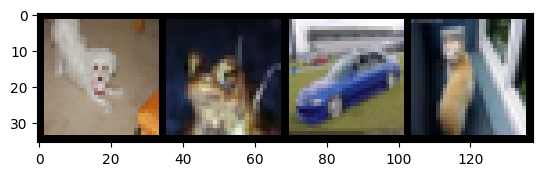

dog frog car cat


In [9]:
# testing 

dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(" ".join([classes[labels[i]] for i in range(batch_size)]))

In [10]:
# load the model

model = Net()
model.load_state_dict(torch.load("./cifar_model.pth"))

<All keys matched successfully>

In [11]:
# Predict

outputs = model(images)
value,out = torch.max(outputs,1)
print(" ".join([classes[out[i]] for i in range(batch_size)]))

frog ship car dog


In [12]:
# Accuracy

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        image, label = data
        
        outputs = model(image)
        value, out = torch.max(outputs.data,1)
        
        total += label.size(0)
        correct += (out == label).sum().item()

print("Accuracy of the network : ", 100*correct//total, "%")

Accuracy of the network :  69 %


In [13]:
# Accuracy per class

correct_pred = {i:0 for i in classes}
total_pred = {i:0 for i in classes}
ans = 0

with torch.no_grad():
    for data in testloader:
        image, label = data
        
        outputs = model(image)
        value, out = torch.max(outputs.data,1)
        
        for i, j in zip(label,out):
            if i == j:
                correct_pred[classes[i]] += 1
                ans += 1
            total_pred[classes[i]] += 1

for name, cc in correct_pred.items():
    acc = 100*cc / total_pred[name]
    print(f"Accuracy for class : {name} is {acc} %")

Accuracy for class : plane is 72.4 %
Accuracy for class : car is 77.6 %
Accuracy for class : bird is 62.2 %
Accuracy for class : cat is 42.6 %
Accuracy for class : deer is 61.1 %
Accuracy for class : dog is 59.6 %
Accuracy for class : frog is 72.5 %
Accuracy for class : horse is 79.8 %
Accuracy for class : ship is 84.8 %
Accuracy for class : truck is 83.7 %
